# Titanic challenge part 1
In this notebook, we will be covering all of the steps required to wrangle the Titanic data set into a format that is suitable for machine learning.   
We will do each of the following:
  - impute missing values
  - create new features (feature engineering)
  
[**Part 2**](https://www.kaggle.com/jamesleslie/titanic-random-forest-grid-search) of this challenge involves fitting and tuning a **random forest** to make predictions.

# Table of Contents:

- **1. [Load Packages and Data](#loading)**
- **2. [Imputation](#impute-missing)**
  - **2.1. [Age](#age)**
  - **2.1. [Fare](#fare)**
  - **2.1. [Embarked](#embarked)**
- **3. [Feature engineering](#feature-engineering)**

<a id="loading"></a>
# 1. Load packages and data
First step, as always, is to import the necessary Python packages and load the input data as a Pandas dataframe.

I chose to combine the train and test set into one. Since we will have to impute some missing age and fare values, I prefer to do this across the entire dataset, rather than separately across train and test sets. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(os.listdir("../input"))

In [12]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [14]:
# Load data as Pandas dataframe
train = pd.read_csv('train.csv' )
test = pd.read_csv('test.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [15]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [16]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1046,NaN,NaN,NaN,29.8811,14.4135,0.17,21,28,39,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1307,3,S,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [17]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

<a id="impute-missing"></a>
# 2. Imputation 
We can see above that there are a few columns with missing values. The `Cabin` column is missing over 1000 values, so we won't use that for predictions, but the `Age`, `Embarked` and `Fare` columns are all complete enough that we can fill in the missing values through imputation.   
<a id="age"></a>
## 2.1. Impute missing age values
A simple option for the missing age values is to use the median age value. Let's go a little further and use each passenger's *Title* to estimate their age. E.g. if a passenger has the title of *Dr*, I will give them the median age value for all other passengers with the same title.

### Extract title from name
We can use a regular expression to extract the title from the `Name` column. We will do this by finding the adjacent letters that are immediately followed by a full stop.


In [18]:
# create new Title column
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [19]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


### Use only the most common titles
Let's take a look at the unique titles across all passengers:

In [20]:
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Countess      1
Mme           1
Capt          1
Lady          1
Sir           1
Don           1
Dona          1
Jonkheer      1
Name: Title, dtype: int64

As we can see above, there are quite a few different titles. However, many of these titles are just French versions of the more common English titles, e.g. Mme = Madame = Mrs.   

We will use the six most common titles, replacing all other titles with the most appropriate of these six.

In [21]:
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

In [22]:
# confirm that we are left with just six values
df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

### Use median of title group
Now, for each missing age value, we will impute the age using the median age for all people with the same title.

In [23]:
# impute missing Age values using median of Title groups
title_ages = dict(df.groupby('Title')['Age'].median())

# create a column of the average ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

We can visualize the median ages for each title group. Below, we see that each title has a distinctly different median age. 
> **Note**: There is no risk in doing this after imputation, as the median of an age group has not been affected by our actions.

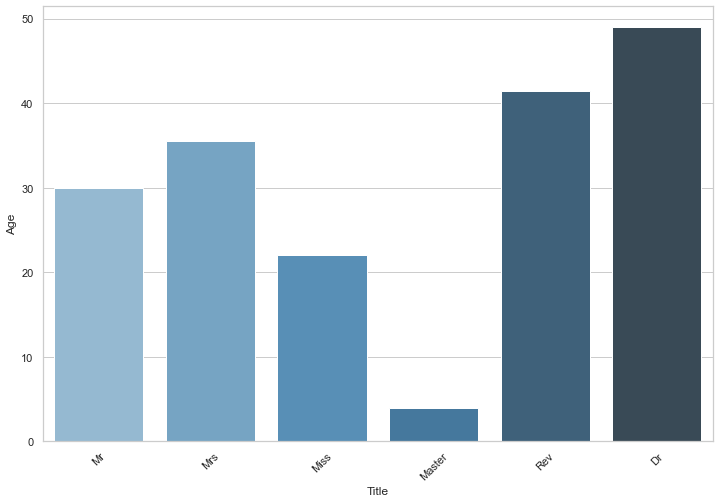

In [24]:
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

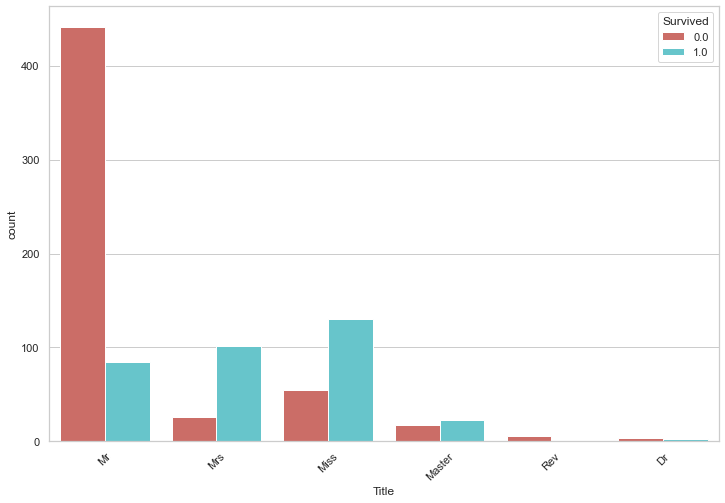

In [25]:
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

<a id="fare"></a>
## 2.2. Impute missing fare values
For the single missing fare value, I also use the median fare value for the passenger's class.   

> Perhaps you could come up with a cooler way of visualising the relationship between the price a passenger paid for their ticket and their chances of survival?

C:\Users\Lereko Qholosha\anaconda3\New folder\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Lereko Qholosha\anaconda3\New folder\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


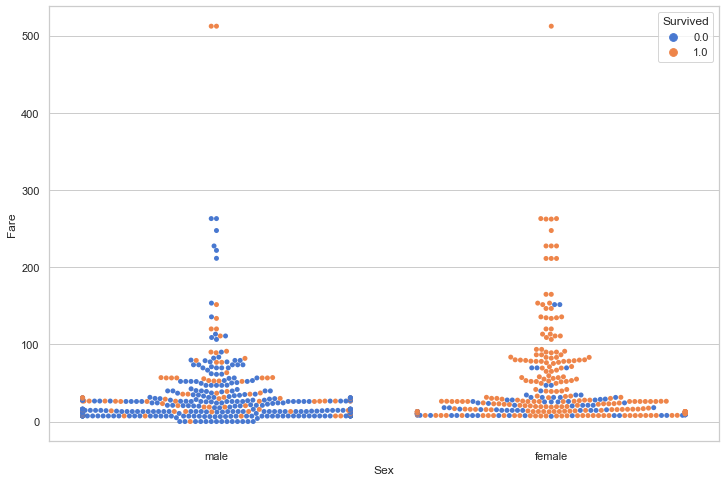

In [33]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=df)
plt.show()

In [ ]:
# impute missing Fare values using median of Pclass groups
class_fares = dict(df.groupby('Pclass')['Fare'].median())

# create a column of the average fares
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

<a id="embarked"></a>
## 2.3. Impute missing "embarked" value
There are also just two missing values in the `Embarked` column. Here we will just use the Pandas 'backfill' method.


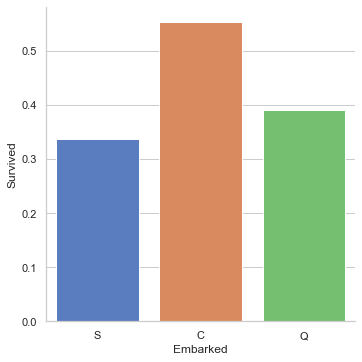

In [27]:
sns.catplot(x='Embarked', y='Survived', data=df,
            kind='bar', palette='muted', ci=None)
plt.show()

In [28]:
df['Embarked'].fillna(method='backfill', inplace=True)

<a id="feature-engineering"></a>
# 3. Add family size column
We can use the two variables of **Parch** and **SibSp** to create a new variable called **Family_Size**. This is simply done by adding `Parch` and `SibSp` together.

In [29]:
# create Family_Size column (Parch +)
df['Family_Size'] = df['Parch'] + df['SibSp']

In [30]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


# 4. Save cleaned version
Finally, let's save our cleaned data set so we can use it in other notebooks.

In [31]:
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]

In [32]:
train.to_csv('train_clean.csv', index=False)
test.to_csv('test_clean.csv', index=False)